In [150]:
# Librerias generales

# Pandas
import pandas as pd
import math
pd.set_option('display.max_columns', 50) # Número máximo de columnas a mostrar
pd.set_option('display.max_rows', 50) # Número máximo de filas a mostar

# Random seed
import numpy as np
np.random.seed(3301)

# Seaborn
import seaborn as sns 

# Matplolib
%matplotlib inline
import matplotlib.pyplot as plt

# math


# scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

db_location = './Datos/datos_entrenamiento_laboratorio1(train_data).csv'
data = pd.read_csv(db_location, sep=',')
data.shape 

from joblib import dump, load


In [151]:
import pandas as pd
import numpy as np

def limpiar_datos(df: pd.DataFrame) -> pd.DataFrame:

    df = df.copy()

    # 1) market_value → precio_millones (en unidades monetarias, no “millones”)
    if 'market_value' in df.columns:
        mv = (
            df['market_value']
            .astype('string')
            .str.lower()
            .str.strip()
            .replace({'-': np.nan, 'error': np.nan})
        )
        # Captura número con posible decimal y sufijo m/k
        ext = mv.str.extract(r'€?\s*([\d]+(?:\.[\d]+)?)\s*([mk]?)', expand=True)
        ext.columns = ['cantidad', 'sufijo']
        cantidad = pd.to_numeric(ext['cantidad'], errors='coerce')  # respeta '.' como decimal
        mult = ext['sufijo'].map({'m': 1_000_000.0, 'k': 1_000.0}).fillna(1.0)
        df['precio_millones'] = cantidad * mult
    
        df = df[df['precio_millones'] < 1e10*0.1]

    # 2) Dia_partido: quitar sufijos y parsear con formato
    if 'Dia_partido' in df.columns:
        col = df['Dia_partido'].astype('string')
        for suf in [" North", " West", " Derby", " El", " Choc"]:
            col = col.str.replace(suf, "", regex=False)
        df['Dia_partido'] = pd.to_datetime(col, format="%A %B %d, %Y")

    # 3) Edad: normalizar y convertir a float
    if 'Edad' in df.columns:
        df['Edad'] = (
            df['Edad'].astype('string').str.replace('-', '.', regex=False)
        )
        df['Edad'] = df['Edad'].astype(float)  # sin errors='coerce' para replicar el lab

    # 4) Correcciones puntuales de Nacionalidad (si aplica)
    if {'Jugador', 'Nacionalidad'}.issubset(df.columns):
        df.loc[df['Jugador'].eq('Fer Lopez'), 'Nacionalidad'] = 'es ESP'
        df.loc[df['Jugador'].eq('Mateus Mane'), 'Nacionalidad'] = 'pt POR'
    
    # 5) Quitar columnas duplicadas (por contenido)
    df = df.loc[:, ~df.T.duplicated()]

    # 6) Goles entre 0 y 15
    if 'Goles' in df.columns:
        df = df[(df['Goles'] >= 0) & (df['Goles'] <= 15)]
    
    df = pd.get_dummies(df, columns=['Nacionalidad'], drop_first=False, dtype=float)

    number_columns = df.select_dtypes(include=[np.number]).columns
    return df[number_columns]






In [152]:
# datos = pd.read_csv(db_location, sep=',')
# dffinal = limpiar_datos(datos)
# dffinal.shape
# dffinal
# # 3) Selección de numéricas y armado de matrices
# number_columns = dffinal.select_dtypes(include=[np.number]).columns
# test  = dffinal[number_columns].dropna()
# train = test.drop(columns=['precio_millones'])

# print(train.shape)  # esperado: (15912, 33)

# r_train_max = 0
# i_train= 0
# r_test_max = 0
# i_test = 0
# print("Buscando mejor random_state...", end='\r')
# for i in range (100):
#     print(f"=== Iteración {i+1} ===", end='\r')
#     X_train, X_test, y_train, y_test = train_test_split(
#         train, test["precio_millones"], test_size=0.3, random_state=i
#     )

#     reg = LinearRegression().fit(X_train, y_train)

#     r_train = reg.score(X_train, y_train)
#     r_test = reg.score(X_test, y_test)
#     if r_train > r_train_max:
#         r_train_max = r_train
#         i_train = i
#     if r_test > r_test_max:
#         r_test_max = r_test
#         i_test = i

# X_train, X_test, y_train, y_test = train_test_split(
#         train, test["precio_millones"], test_size=0.3, random_state=i_test
#     )
# print("_____________Máximo_____________")
# print("Train MAE:",  mean_absolute_error(y_train, reg.predict(X_train)))
# print("Test MAE:",   mean_absolute_error(y_test,  reg.predict(X_test)))
# print("Train RMSE:", np.sqrt(mean_squared_error(y_train, reg.predict(X_train))))
# print("Test RMSE:",  np.sqrt(mean_squared_error(y_test,  reg.predict(X_test))))
# print("Train R²:",   reg.score(X_train, y_train))
# print("Test R²:",    reg.score(X_test,  y_test))
# print("________________________________\n")



In [153]:
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from typing import Optional


class FutAlpesRegressionPipeline(BaseEstimator, RegressorMixin):
    def __init__(self):
        print("Inicializando el pipeline de regresión FutAlpes...")
        self.pipeline = Pipeline([
            ('regressor', LinearRegression())
        ])

        self.model = LinearRegression()
        self.trained = False
        self.feature_columns_: Optional[list[str]] = None

    

    def fit(self, X: pd.DataFrame, y = None):
        print("Entrenando el modelo...")
        data = X.copy()
        
        dffinal = limpiar_datos(data)
        number_columns = dffinal.select_dtypes(include=[np.number]).columns
        data_test  = dffinal[number_columns].dropna()
        data_train = data_test.drop(columns=['precio_millones'])
        
        print(number_columns)
        r_train_max = 0
        i_train = 0
        r_test_max = 0
        i_test = 0

        self.feature_columns_ = data_train.columns.tolist()

        print("Buscando mejor random_state...", end='\r')
        for i in range(0):
            X_train, X_test, y_train, y_test = train_test_split(
            data_train, data_test['precio_millones'], test_size=0.3, random_state=i
            )
            self.pipeline.fit(X_train, y_train)
            r_train = self.pipeline.score(X_train, y_train)
            r_test = self.pipeline.score(X_test, y_test)
            if r_train > r_train_max:
                r_train_max = r_train
                i_train = i
            if r_test > r_test_max:
                r_test_max = r_test
                i_test = i

        X_train, X_test, y_train, y_test = train_test_split(
            data_train, data_test['precio_millones'], test_size=0.3, random_state=i_test
        )
        self.pipeline.fit(X_train, y_train)
        y_train_pred = self.pipeline.predict(X_train)
        y_test_pred = self.pipeline.predict(X_test)
        print("====== Model Performance ======")
        print("Train MAE:", mean_absolute_error(y_train, y_train_pred))
        print("Test MAE:", mean_absolute_error(y_test, y_test_pred))
        print("Train RMSE:", np.sqrt(mean_squared_error(y_train, y_train_pred)))
        print("Test RMSE:", np.sqrt(mean_squared_error(y_test, y_test_pred)))
        print("Train R²:", r2_score(y_train, y_train_pred))
        print("Test R²:", r2_score(y_test, y_test_pred))
        print("===============================\n")

        self.pipeline.fit(data_train, data_test["precio_millones"])
        self.is_fitted_ = True
        
        return self
        
    def arreglar_datos(self, df: pd.DataFrame) -> pd.DataFrame:
        df = df.copy()
        df = limpiar_datos(df)
        return df
    
    def predict(self, X: pd.DataFrame) -> np.ndarray:
        if not self.is_fitted_:
            raise RuntimeError("El modelo no está entrenado. Llama primero a .fit().")

        df = limpiar_datos(X.copy())
        df_num = df.select_dtypes(include=[np.number]).copy()

        # Asegurar que existen todas las columnas usadas en entrenamiento
        # (si faltan, las creamos con 0; si sobran, las ignoramos)
        for col in self.feature_columns_:
            if col not in df_num.columns:
                df_num[col] = 0.0

        X_pred = df_num[self.feature_columns_].copy()

        # Cuidado: si llega a estar la columna objetivo en X, quítala
        if 'precio_millones' in X_pred.columns:
            X_pred = X_pred.drop(columns=['precio_millones'])

        # Eliminar filas con NaN para evitar errores
        X_pred = X_pred.dropna()

        return self.pipeline.predict(X_pred)

In [154]:
datos = pd.read_csv(db_location, sep=',')

modelo = FutAlpesRegressionPipeline()
modelo.fit(datos)

Inicializando el pipeline de regresión FutAlpes...
Entrenando el modelo...
Index(['Edad', 'Goles', 'Tiros Totales', 'xG', 'npxG', 'xAG',
       'Acciones_que_crean_tiros', 'Pases_intentados', 'Pases_progresivos',
       'Regates_exitosos',
       ...
       'Nacionalidad_tr TUR', 'Nacionalidad_ua UKR', 'Nacionalidad_us USA',
       'Nacionalidad_uy URU', 'Nacionalidad_uz UZB', 'Nacionalidad_ve VEN',
       'Nacionalidad_wls WAL', 'Nacionalidad_xk KVX', 'Nacionalidad_zm ZAM',
       'Nacionalidad_zw ZIM'],
      dtype='object', length=135)
====== Model Performance ======
Train MAE: 12724225.877899002
Test MAE: 13205673.334391017
Train RMSE: 19380710.524729468
Test RMSE: 20530717.289175015
Train R²: 0.27962170903158334
Test R²: 0.2595021507891736



FutAlpesRegressionPipeline()

# Guardar

In [155]:
datos = pd.read_csv(db_location, sep=',')
model_pipeline = FutAlpesRegressionPipeline()
model_pipeline.fit(datos)

dump(model_pipeline, "pipeline.joblib")
print("Modelo exportado como model_pipeline.joblib\n")

Inicializando el pipeline de regresión FutAlpes...
Entrenando el modelo...
Index(['Edad', 'Goles', 'Tiros Totales', 'xG', 'npxG', 'xAG',
       'Acciones_que_crean_tiros', 'Pases_intentados', 'Pases_progresivos',
       'Regates_exitosos',
       ...
       'Nacionalidad_tr TUR', 'Nacionalidad_ua UKR', 'Nacionalidad_us USA',
       'Nacionalidad_uy URU', 'Nacionalidad_uz UZB', 'Nacionalidad_ve VEN',
       'Nacionalidad_wls WAL', 'Nacionalidad_xk KVX', 'Nacionalidad_zm ZAM',
       'Nacionalidad_zw ZIM'],
      dtype='object', length=135)
====== Model Performance ======
Train MAE: 12724225.877899002
Test MAE: 13205673.334391017
Train RMSE: 19380710.524729468
Test RMSE: 20530717.289175015
Train R²: 0.27962170903158334
Test R²: 0.2595021507891736

Modelo exportado como model_pipeline.joblib



In [156]:
datos = pd.read_csv(db_location, sep=',')
model_pipeline = FutAlpesRegressionPipeline()
model_pipeline.fit(datos)

dump(model_pipeline, "pipeline.joblib")
print("Modelo exportado como model_pipeline.joblib\n")

Inicializando el pipeline de regresión FutAlpes...
Entrenando el modelo...
Index(['Edad', 'Goles', 'Tiros Totales', 'xG', 'npxG', 'xAG',
       'Acciones_que_crean_tiros', 'Pases_intentados', 'Pases_progresivos',
       'Regates_exitosos',
       ...
       'Nacionalidad_tr TUR', 'Nacionalidad_ua UKR', 'Nacionalidad_us USA',
       'Nacionalidad_uy URU', 'Nacionalidad_uz UZB', 'Nacionalidad_ve VEN',
       'Nacionalidad_wls WAL', 'Nacionalidad_xk KVX', 'Nacionalidad_zm ZAM',
       'Nacionalidad_zw ZIM'],
      dtype='object', length=135)
====== Model Performance ======
Train MAE: 12724225.877899002
Test MAE: 13205673.334391017
Train RMSE: 19380710.524729468
Test RMSE: 20530717.289175015
Train R²: 0.27962170903158334
Test R²: 0.2595021507891736

Modelo exportado como model_pipeline.joblib



In [157]:
pipeline = load("pipeline.joblib")

In [158]:
db_location = './Datos/datos_entrenamiento_laboratorio1(train_data).csv'
datos = pd.read_csv(db_location, sep=',')

pipeline.predict(datos.head())

C:\Users\esteb\AppData\Local\Temp\ipykernel_21704\3522070421.py:90: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_num[col] = 0.0
C:\Users\esteb\AppData\Local\Temp\ipykernel_21704\3522070421.py:90: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_num[col] = 0.0
C:\Users\esteb\AppData\Local\Temp\ipykernel_21704\3522070421.py:90: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(ax

array([23877838.79125492, 44194858.7046309 , 28222675.32660519])

In [159]:
datos = pd.read_csv(db_location, sep=',')

dffinal = limpiar_datos(datos)

X = dffinal.select_dtypes(include=[np.number]).drop(columns=["precio_millones"])
y = dffinal["precio_millones"]

In [160]:
import seaborn as sns
import matplotlib.pyplot as plt

corr = X.corr().abs()


umbral = 0.7
correlaciones_altas = (
    corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
    .stack()
    .reset_index()
)
correlaciones_altas.columns = ["Var1", "Var2", "Correlación"]
correlaciones_altas = correlaciones_altas[correlaciones_altas["Correlación"] > umbral]

correlaciones_altas.sort_values("Correlación", ascending=False)

,Var1,Var2,Correlación
916,Pases_intentados,Pases_balon_vivo,0.987367
1774,Pases_balon_vivo,Pases_completados,0.985290
920,Pases_intentados,Pases_completados,0.983631
1785,Pases_balon_vivo,Pases_recibidos,0.972587
2251,Pases_completados,Pases_recibidos,0.957208
931,Pases_intentados,Pases_recibidos,0.953280
1292,Pases_medios_completados,Pases_completados,0.924173
396,xG,npxG,0.916417
1288,Pases_medios_completados,Pases_balon_vivo,0.906200
912,Pases_intentados,Pases_medios_completados,0.897967


In [161]:
def eliminar_variables_correlacionadas(df, umbral=0.9):
    
    # Calcular la matriz de correlación
    corr_matrix = df.corr().abs()
    
    # Matriz superior (para no repetir pares i,j y j,i)
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    
    # Lista de variables a eliminar
    eliminadas = [column for column in upper.columns if any(upper[column] > umbral)]
    
    # Retornar dataset reducido y lista de eliminadas
    df_filtrado = df.drop(columns=eliminadas, errors="ignore")
    
    return df_filtrado, eliminadas

In [162]:
umbral = 0.9  # puedes ajustar
X_filtrado, eliminadas = eliminar_variables_correlacionadas(X, umbral=umbral)

# --- 4. Imprimir resultados ---
print("Variables eliminadas por colinealidad:\n", eliminadas)
print("\nShape original:", X.shape)
print("Shape reducido :", X_filtrado.shape)

Variables eliminadas por colinealidad:
 ['npxG', 'Pases_balon_vivo', 'Pases_completados', 'Pases_recibidos']

Shape original: (44787, 134)
Shape reducido : (44787, 130)


In [163]:
corr = X_filtrado.corr().abs()

# Filtrar las correlaciones altas
umbral = 0.7
correlaciones_altas = (
    corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
    .stack()
    .reset_index()
)
correlaciones_altas.columns = ["Var1", "Var2", "Correlación"]
correlaciones_altas = correlaciones_altas[correlaciones_altas["Correlación"] > umbral]

correlaciones_altas.sort_values("Correlación", ascending=False)

,Var1,Var2,Correlación
761,Pases_intentados,Pases_medios_completados,0.897967
2286,Toques_en_zona_ofensiva,Pases_progresivos_recibidos,0.773241
886,Pases_progresivos,Pases_en_ultimo_tercio,0.760539
516,xAG,xA,0.717219
274,Tiros Totales,Toques_en_area_rival,0.702204


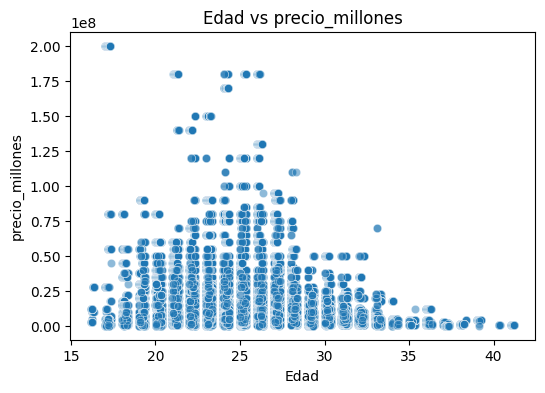

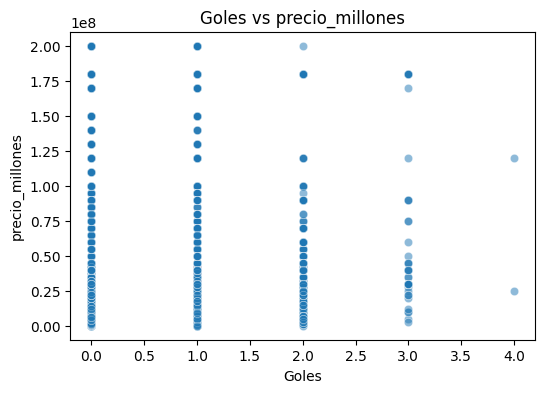

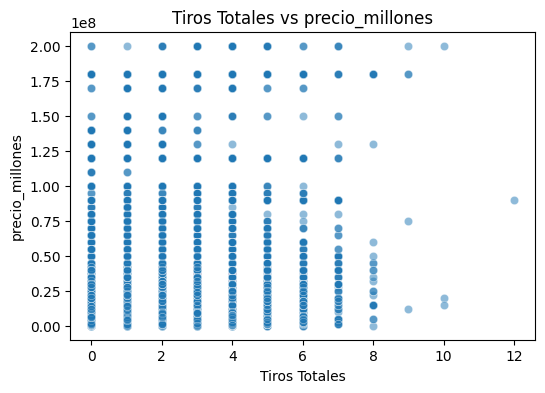

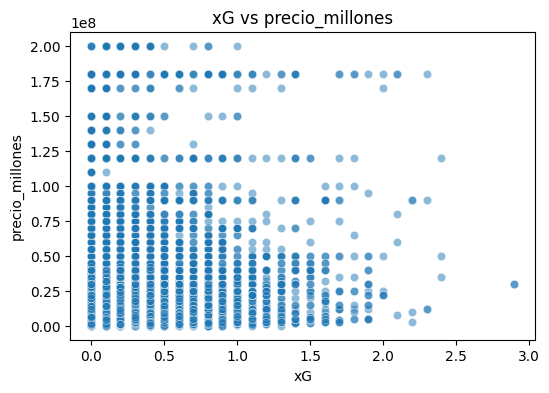

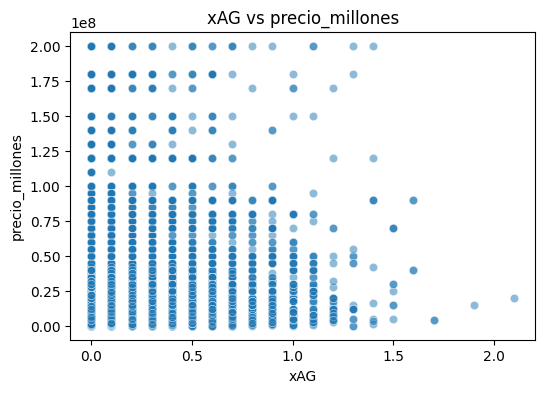

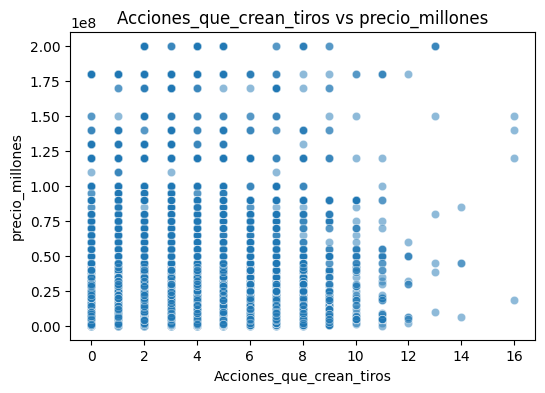

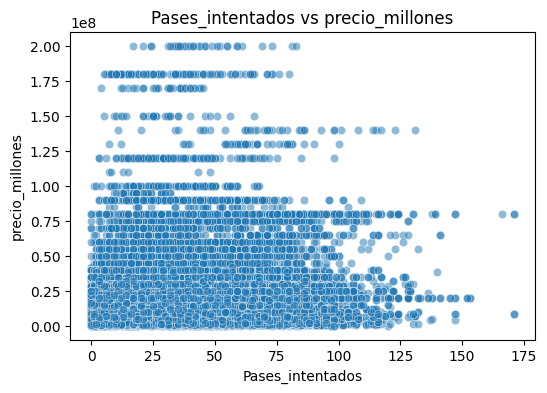

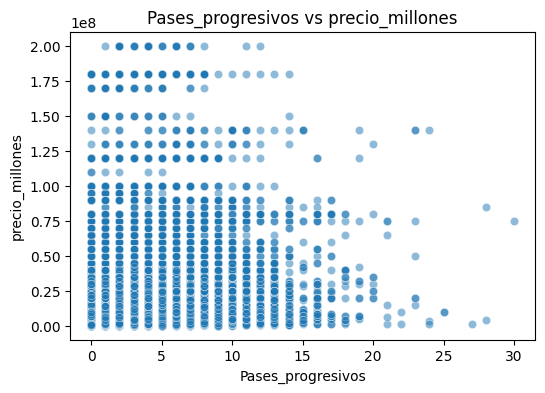

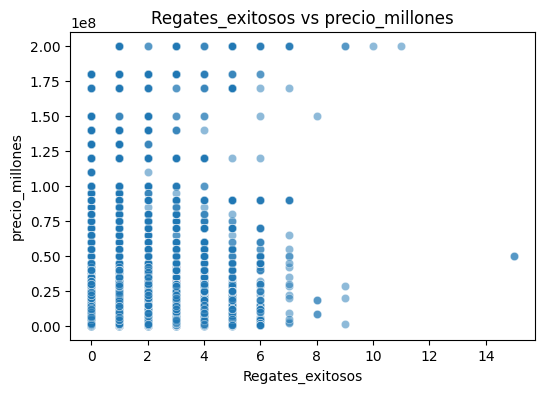

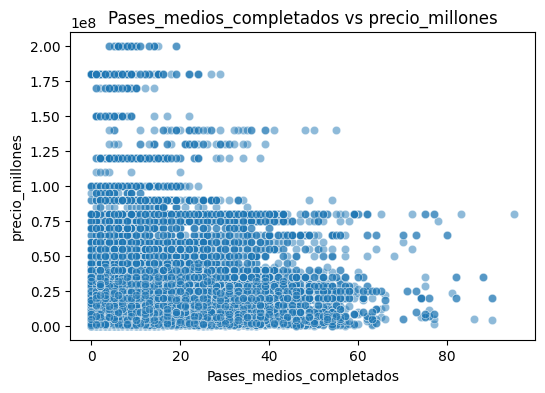

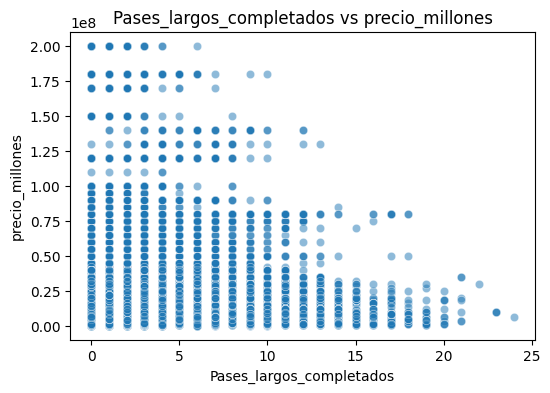

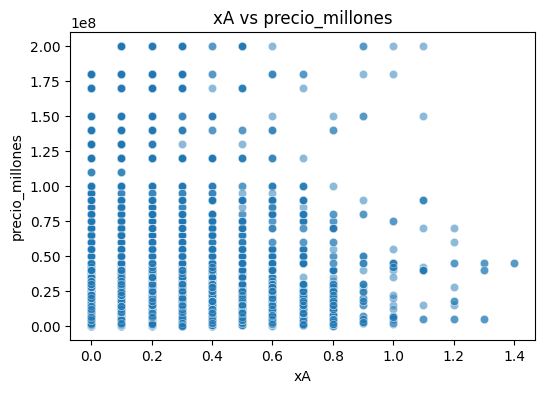

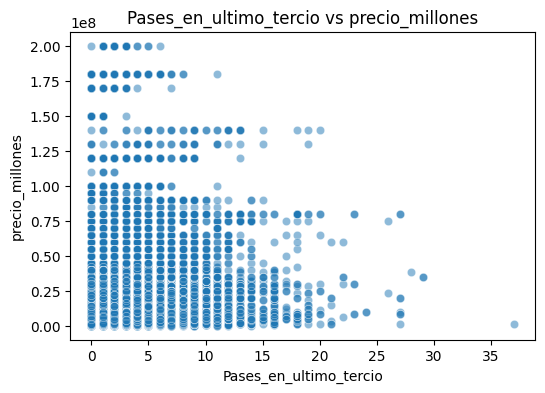

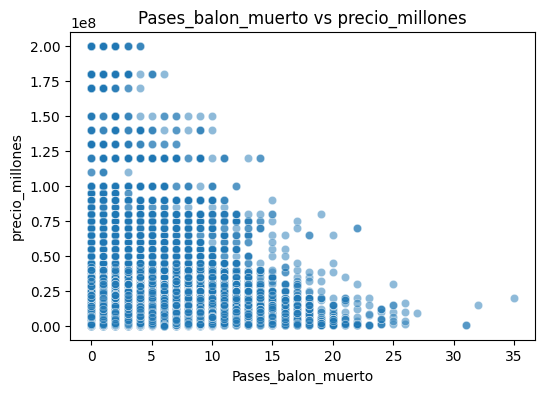

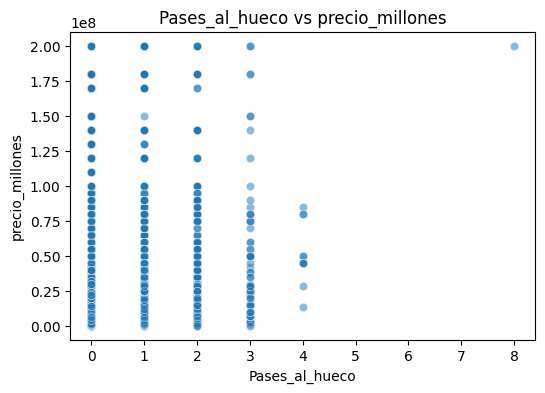

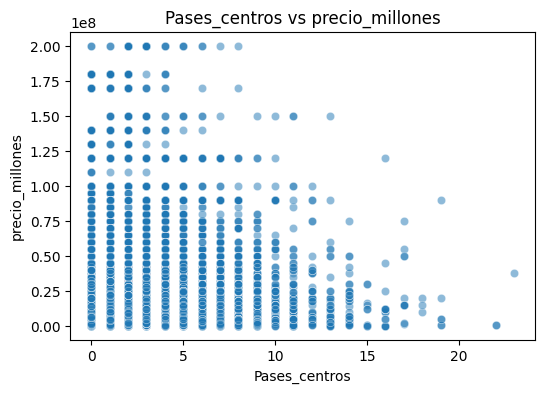

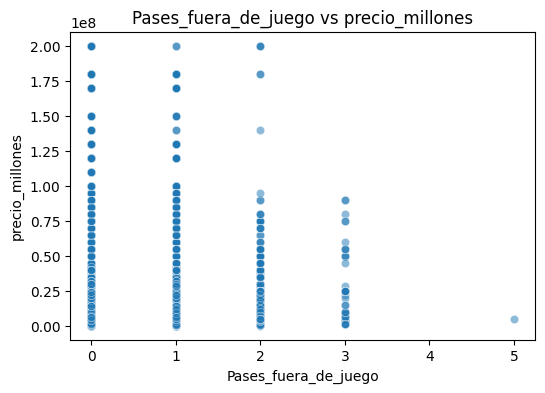

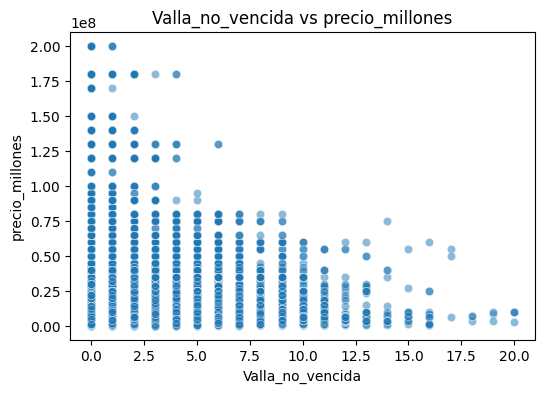

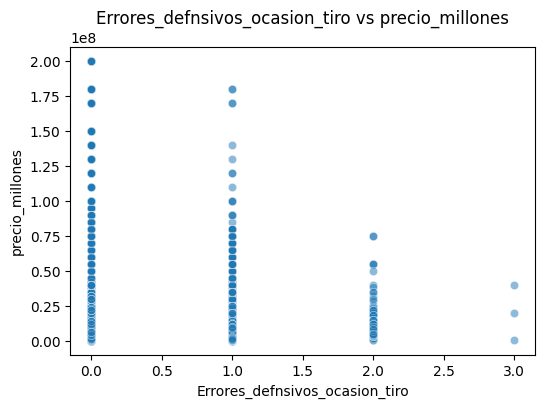

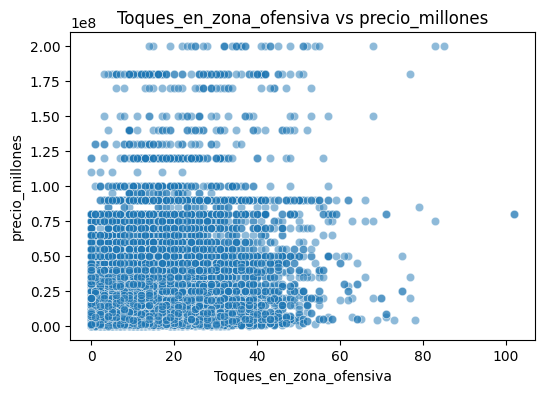

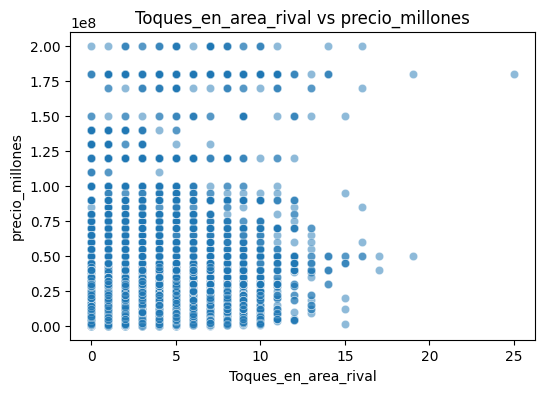

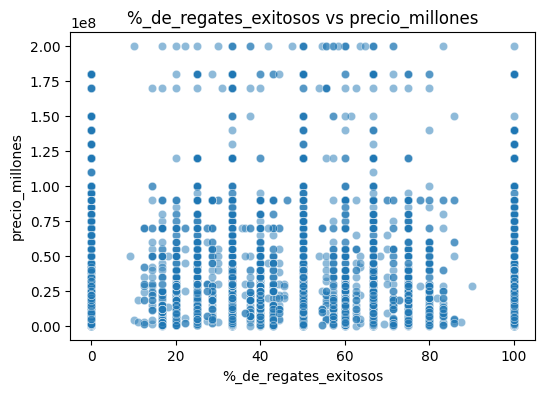

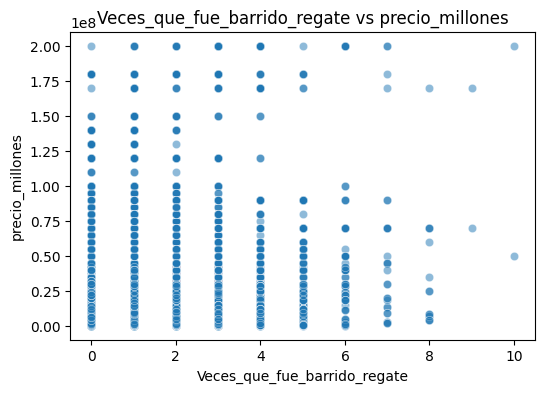

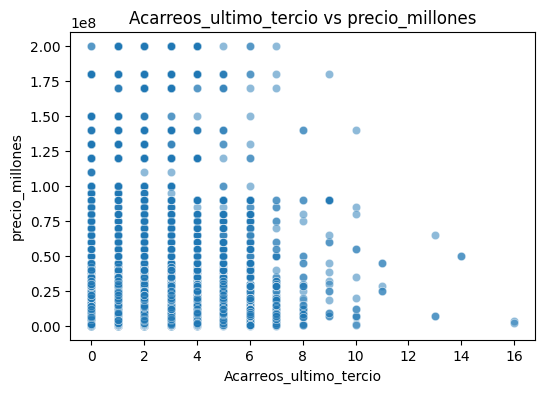

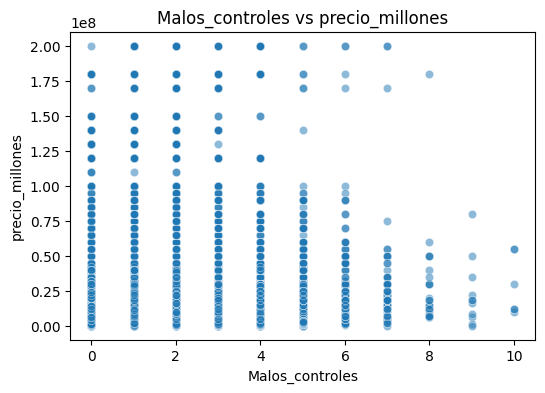

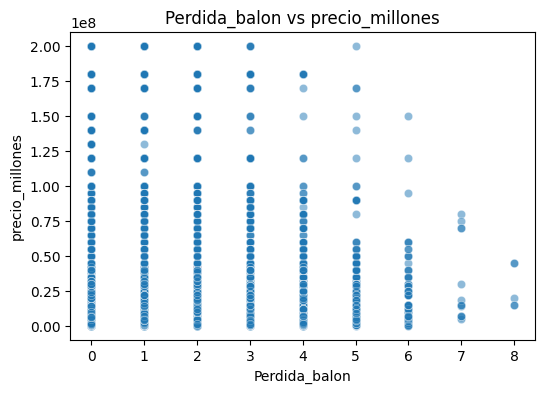

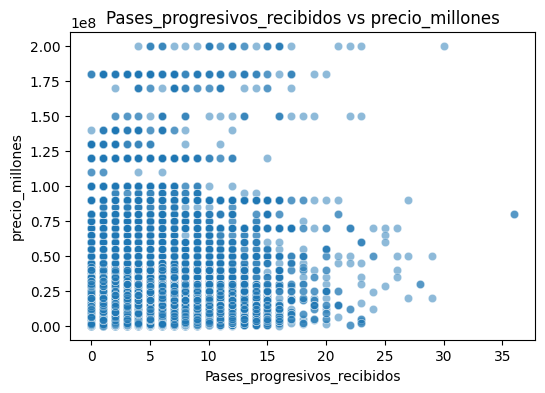

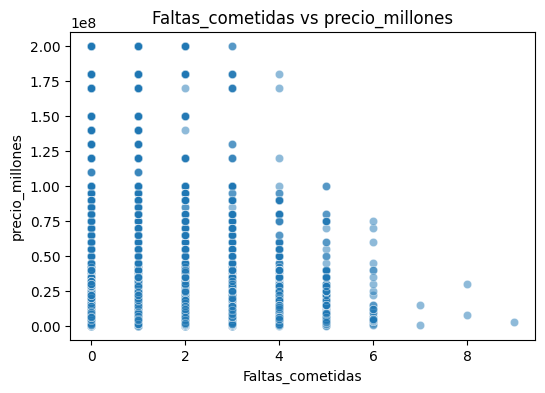

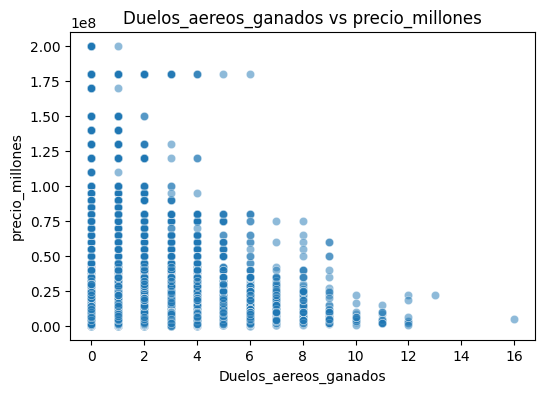

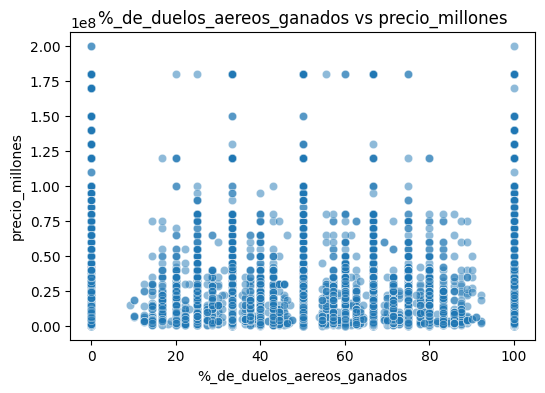

In [164]:
cols_continuas = [col for col in X_filtrado.columns if "Nacionalidad" not in col]

for col in cols_continuas:
    plt.figure(figsize=(6,4))
    sns.scatterplot(x=X_filtrado[col], y=y, alpha=0.5)
    plt.title(f"{col} vs precio_millones")
    plt.xlabel(col)
    plt.ylabel("precio_millones")
    plt.show()

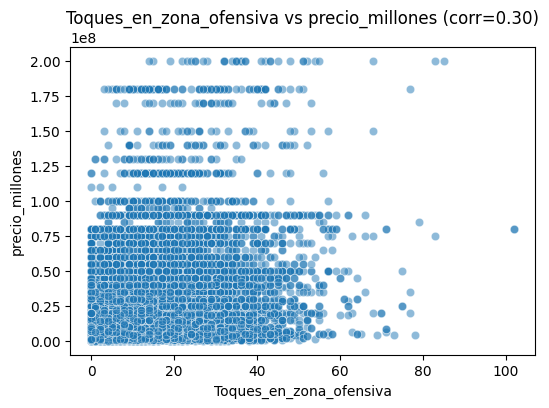

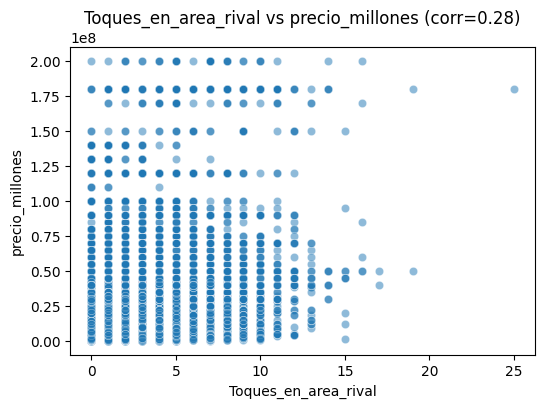

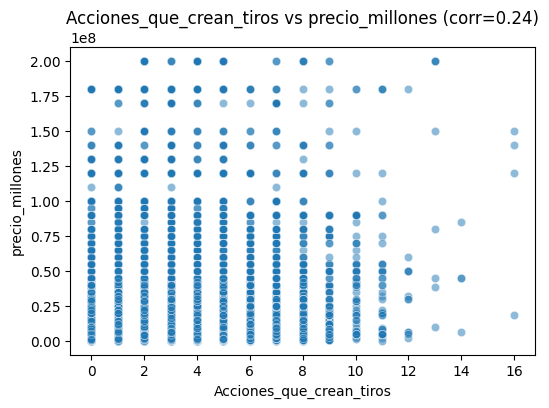

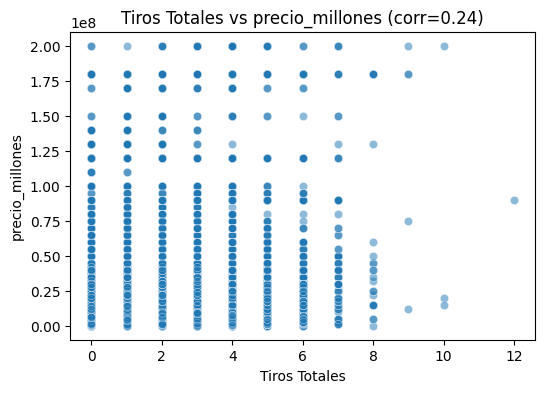

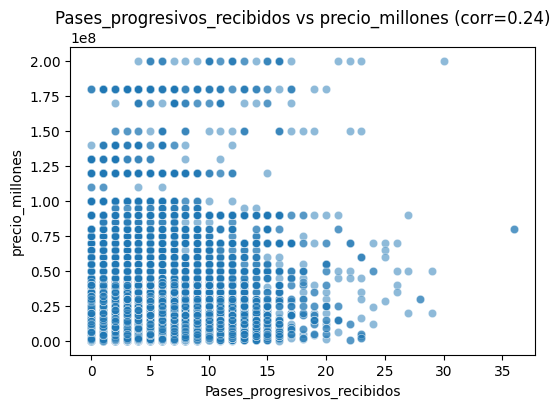

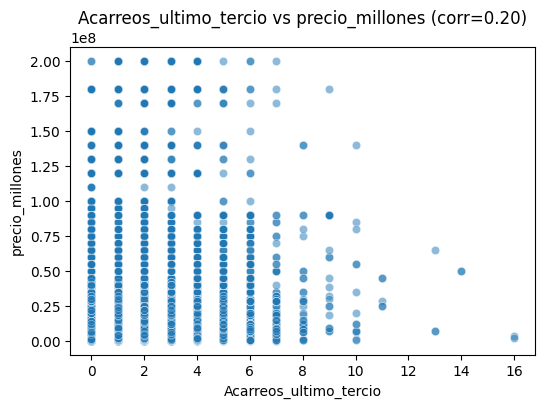

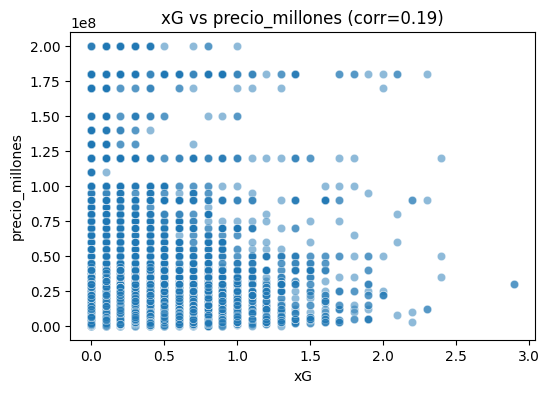

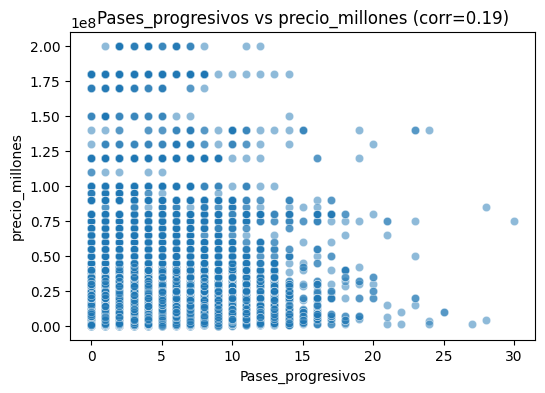

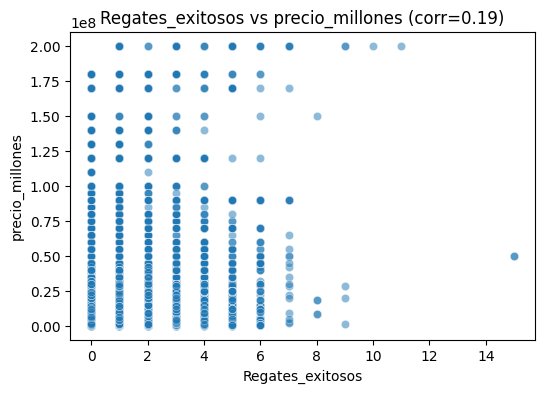

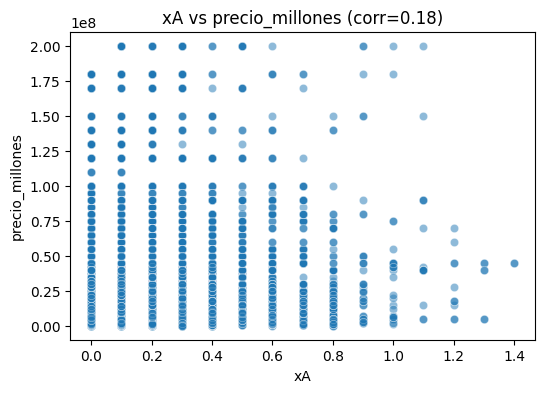

In [165]:
correlaciones_objetivo = X_filtrado[cols_continuas].corrwith(y)

# Ordenar por correlación absoluta
correlaciones_ordenadas = correlaciones_objetivo.abs().sort_values(ascending=False)

# Seleccionar las 11 variables más correlacionadas
top_vars = [col for col in correlaciones_ordenadas.index if col != "Edad"][:10]

# Graficar scatterplots de esas 11 variables contra precio_millones
for col in top_vars:
    plt.figure(figsize=(6,4))
    sns.scatterplot(x=X_filtrado[col], y=y, alpha=0.5)
    plt.title(f"{col} vs precio_millones (corr={correlaciones_objetivo[col]:.2f})")
    plt.xlabel(col)
    plt.ylabel("precio_millones")
    plt.show()

In [166]:
import numpy as np
from scipy.stats import skew

# Copia para no modificar el original
X_trans = X_filtrado.copy()

transformadas = {}

for col in top_vars:
    data = X_filtrado[col]
    asimetria = skew(data)

    if asimetria < -0.5:  # cola izquierda → aplicar potencia
        X_trans[col] = np.power(data, 2)   # o np.power(data, 3)
        transformadas[col] = "potencia (x^2)"
    elif asimetria > 0.5:  # cola derecha → aplicar log1p
        X_trans[col] = np.log1p(data)
        transformadas[col] = "log1p"
    else:
        transformadas[col] = "sin cambio"

print("Transformaciones aplicadas:")
for k,v in transformadas.items():
    print(f"{k}: {v}")


Transformaciones aplicadas:
Toques_en_zona_ofensiva: log1p
Toques_en_area_rival: log1p
Acciones_que_crean_tiros: log1p
Tiros Totales: log1p
Pases_progresivos_recibidos: log1p
Acarreos_ultimo_tercio: log1p
xG: log1p
Pases_progresivos: log1p
Regates_exitosos: log1p
xA: log1p


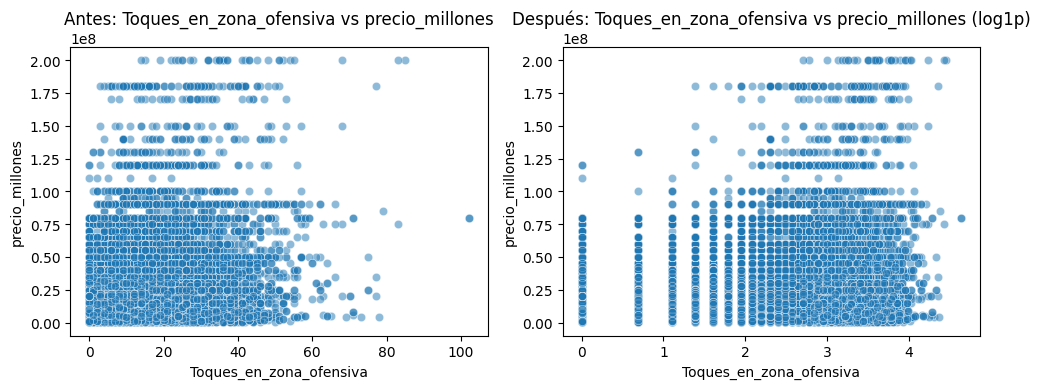

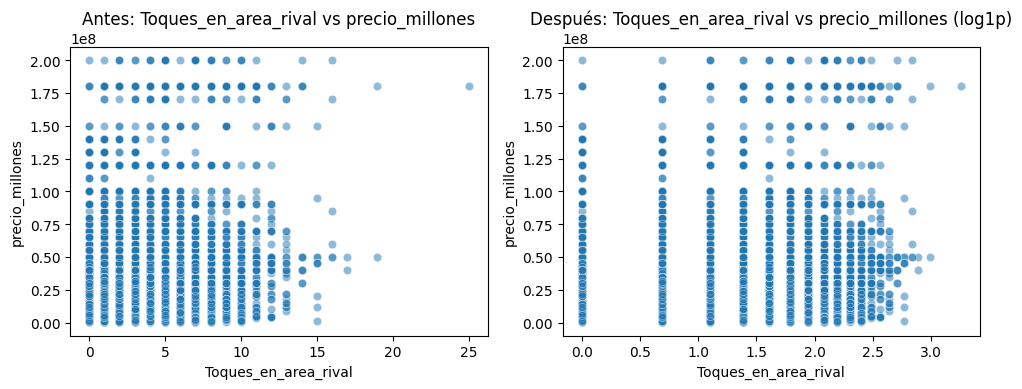

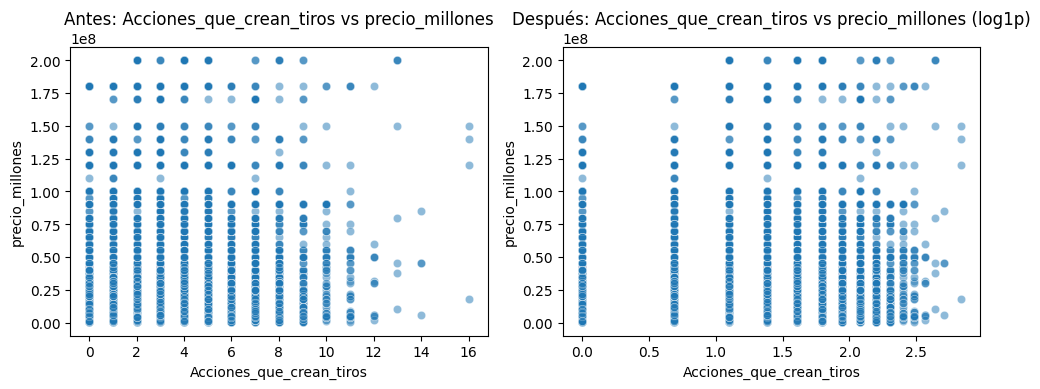

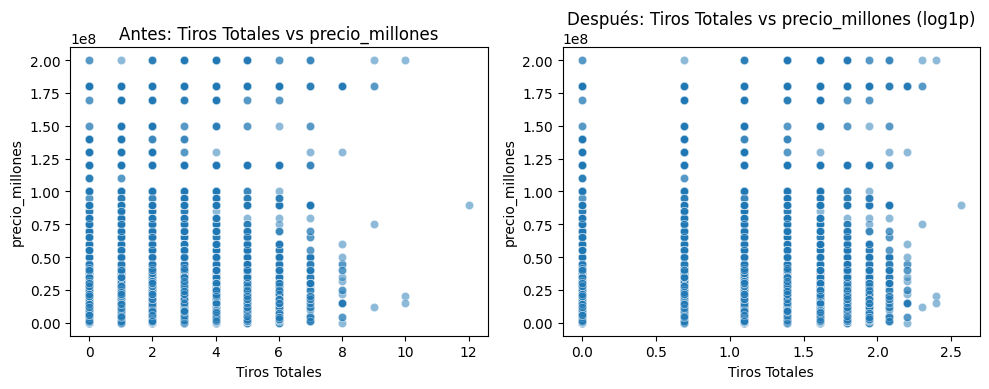

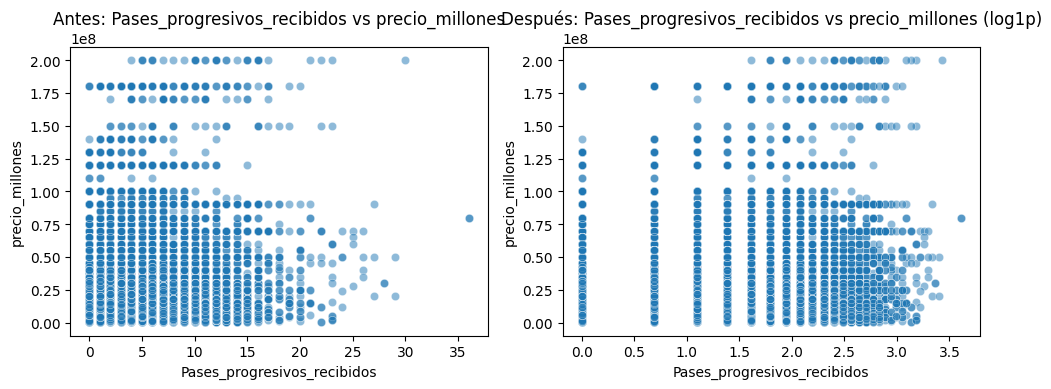

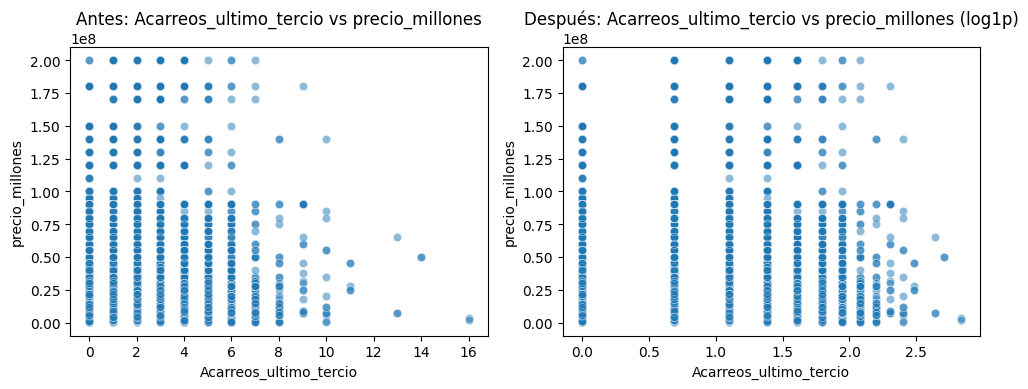

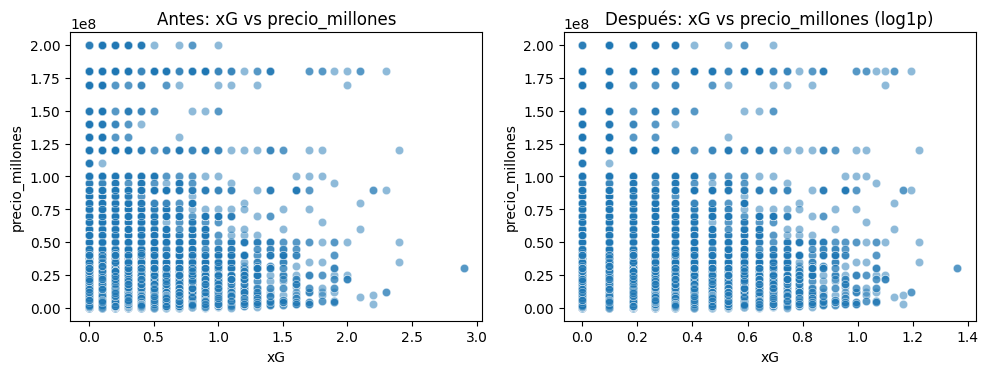

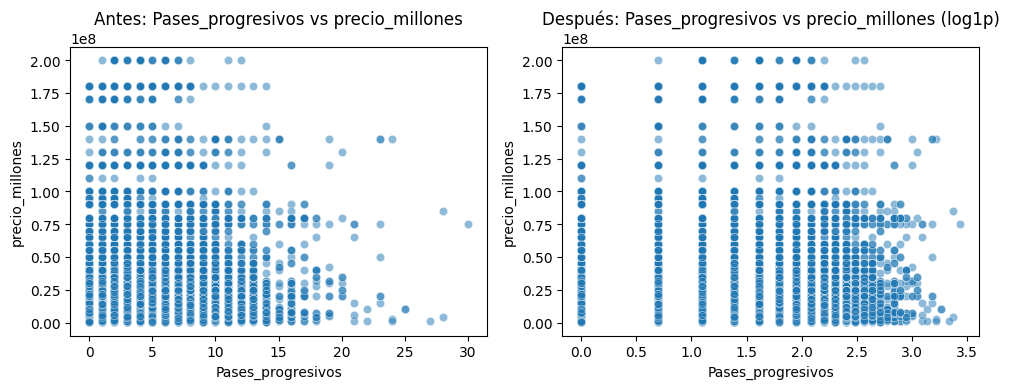

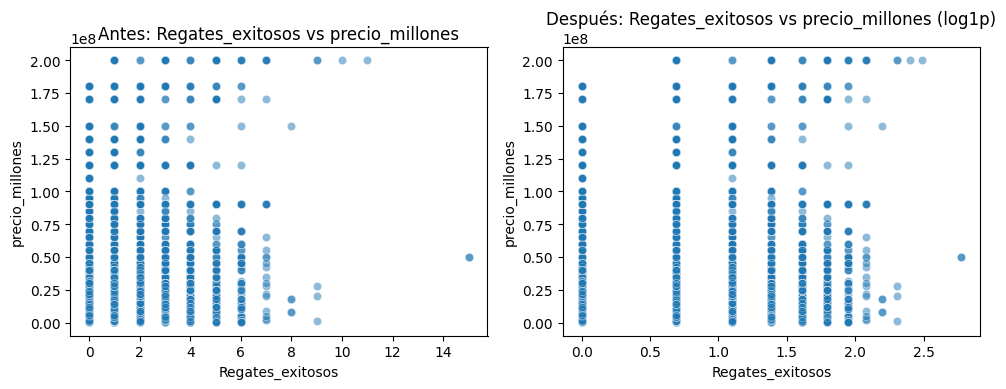

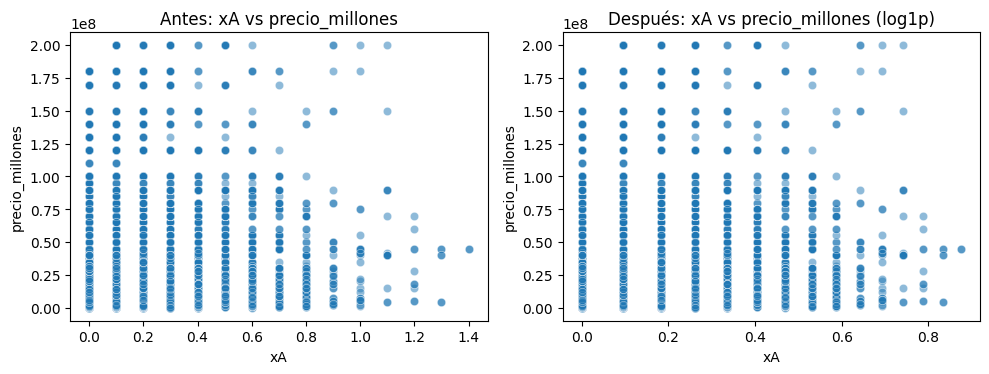

In [167]:
for col in top_vars:
    fig, axes = plt.subplots(1, 2, figsize=(10,4))

    sns.scatterplot(x=X_filtrado[col], y=y, alpha=0.5, ax=axes[0])
    axes[0].set_title(f"Antes: {col} vs precio_millones")
    axes[0].set_xlabel(col)
    axes[0].set_ylabel("precio_millones")

    sns.scatterplot(x=X_trans[col], y=y, alpha=0.5, ax=axes[1])
    axes[1].set_title(f"Después: {col} vs precio_millones ({transformadas[col]})")
    axes[1].set_xlabel(col)
    axes[1].set_ylabel("precio_millones")

    plt.tight_layout()
    plt.show()

In [168]:
nan_cols = X_trans.isna().sum()
print(nan_cols[nan_cols > 0])

df_limpio = X_filtrado.copy()

# 1. Eliminar columnas con muchos nulos
df_limpio = df_limpio.drop(columns=["%_de_regates_exitosos", "%_de_duelos_aereos_ganados"])
df_limpio = df_limpio.copy()
df_limpio["precio_millones"] = dffinal["precio_millones"].values
# 2. Eliminar filas con edad nula
df_limpio = df_limpio.dropna(subset=["Edad"])


Edad                             18
%_de_regates_exitosos         21658
%_de_duelos_aereos_ganados    16090
dtype: int64


In [169]:
nan_cols = df_limpio.isna().sum()
print(nan_cols[nan_cols > 0])
print(df_limpio.columns.tolist())



Series([], dtype: int64)
['Edad', 'Goles', 'Tiros Totales', 'xG', 'xAG', 'Acciones_que_crean_tiros', 'Pases_intentados', 'Pases_progresivos', 'Regates_exitosos', 'Pases_medios_completados', 'Pases_largos_completados', 'xA', 'Pases_en_ultimo_tercio', 'Pases_balon_muerto', 'Pases_al_hueco', 'Pases_centros', 'Pases_fuera_de_juego', 'Valla_no_vencida', 'Errores_defnsivos_ocasion_tiro', 'Toques_en_zona_ofensiva', 'Toques_en_area_rival', 'Veces_que_fue_barrido_regate', 'Acarreos_ultimo_tercio', 'Malos_controles', 'Perdida_balon', 'Pases_progresivos_recibidos', 'Faltas_cometidas', 'Duelos_aereos_ganados', 'Nacionalidad_al ALB', 'Nacionalidad_am ARM', 'Nacionalidad_ao ANG', 'Nacionalidad_ar ARG', 'Nacionalidad_at AUT', 'Nacionalidad_au AUS', 'Nacionalidad_ba BIH', 'Nacionalidad_be BEL', 'Nacionalidad_bf BFA', 'Nacionalidad_bi BDI', 'Nacionalidad_br BRA', 'Nacionalidad_ca CAN', 'Nacionalidad_cd COD', 'Nacionalidad_cf CTA', 'Nacionalidad_cg CGO', 'Nacionalidad_ch SUI', 'Nacionalidad_ci CIV', 'Na

In [170]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# ==============================
# Separar features y target
# ==============================
X = df_limpio.drop(columns=["precio_millones"])
y = df_limpio["precio_millones"]

# ==============================
# Train-test split
# ==============================
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

# ==============================
# Modelo
# ==============================
model = LinearRegression()
model.fit(X_train, y_train)

# ==============================
# Predicciones
# ==============================
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# ==============================
# Métricas
# ==============================
print("====== Model Performance ======")
print("Train MAE:", mean_absolute_error(y_train, y_train_pred))
print("Test MAE:", mean_absolute_error(y_test, y_test_pred))
print("Train RMSE:", np.sqrt(mean_squared_error(y_train, y_train_pred)))
print("Test RMSE:", np.sqrt(mean_squared_error(y_test, y_test_pred)))
print("Train R²:", r2_score(y_train, y_train_pred))
print("Test R²:", r2_score(y_test, y_test_pred))
print("===============================\n")


====== Model Performance ======
Train MAE: 12064928.181315556
Test MAE: 11975156.770041635
Train RMSE: 18810249.90230689
Test RMSE: 18740103.444535047
Train R²: 0.27516093279991916
Test R²: 0.2634282663521941



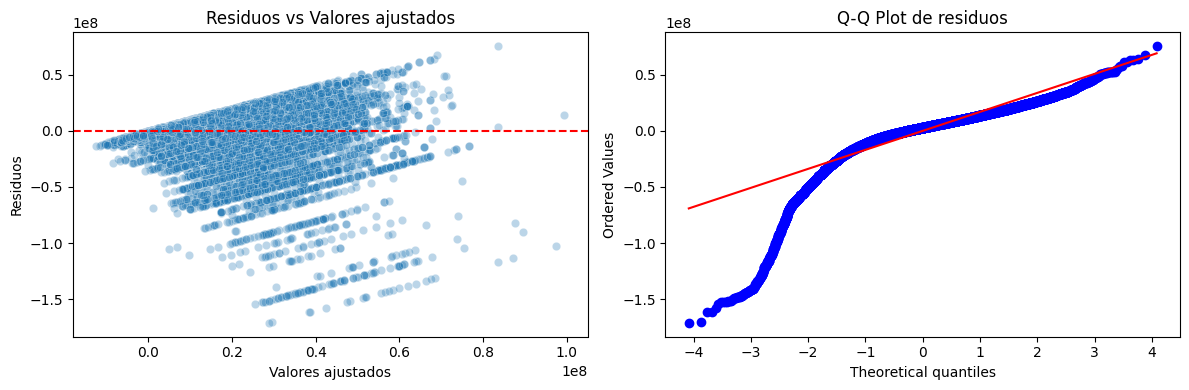

In [ ]:
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

errors = (model.predict(X_train).ravel() - y_train.values.ravel())

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

sns.scatterplot(x=model.predict(X_train).ravel(), 
                y=errors, alpha=0.3, ax=axes[0])
axes[0].axhline(0, color="red", linestyle="--")
axes[0].set_xlabel("Valores ajustados")
axes[0].set_ylabel("Residuos")
axes[0].set_title("Residuos vs Valores ajustados")

stats.probplot(errors, dist="norm", plot=axes[1])
axes[1].set_title("Q-Q Plot de residuos")

plt.tight_layout()
plt.show()


In [172]:
coeficientes = pd.DataFrame({
    "Variable": X_train.columns,
    "Coeficiente": model.coef_.ravel()
})

# Filtrar: excluir columnas de país
coef_filtrados = coeficientes[~coeficientes["Variable"].str.startswith("Nacionalidad_")]

# Ordenar de mayor a menor impacto
coef_filtrados = coef_filtrados.sort_values(by="Coeficiente", ascending=False)

# Mostrar resultados
display(coef_filtrados.head(15))   # Top 15 variables
display(coef_filtrados.tail(15))   # Las más negativas

,Variable,Coeficiente
4,xAG,4.863422e+06
3,xG,3.490901e+06
1,Goles,3.219567e+06
14,Pases_al_hueco,2.373008e+06
18,Errores_defnsivos_ocasion_tiro,1.366822e+06
20,Toques_en_area_rival,1.326259e+06
8,Regates_exitosos,1.125085e+06
19,Toques_en_zona_ofensiva,4.697355e+05
16,Pases_fuera_de_juego,4.612003e+05
21,Veces_que_fue_barrido_regate,4.347280e+05


,Variable,Coeficiente
12,Pases_en_ultimo_tercio,8.798097e+04
9,Pases_medios_completados,6.221240e+04
2,Tiros Totales,1.151148e+04
25,Pases_progresivos_recibidos,4.272541e+03
7,Pases_progresivos,-6.933976e+04
22,Acarreos_ultimo_tercio,-1.214983e+05
24,Perdida_balon,-1.218343e+05
17,Valla_no_vencida,-1.449479e+05
13,Pases_balon_muerto,-3.376633e+05
11,xA,-4.346329e+05


C:\Users\esteb\AppData\Local\Temp\ipykernel_21704\3886028246.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


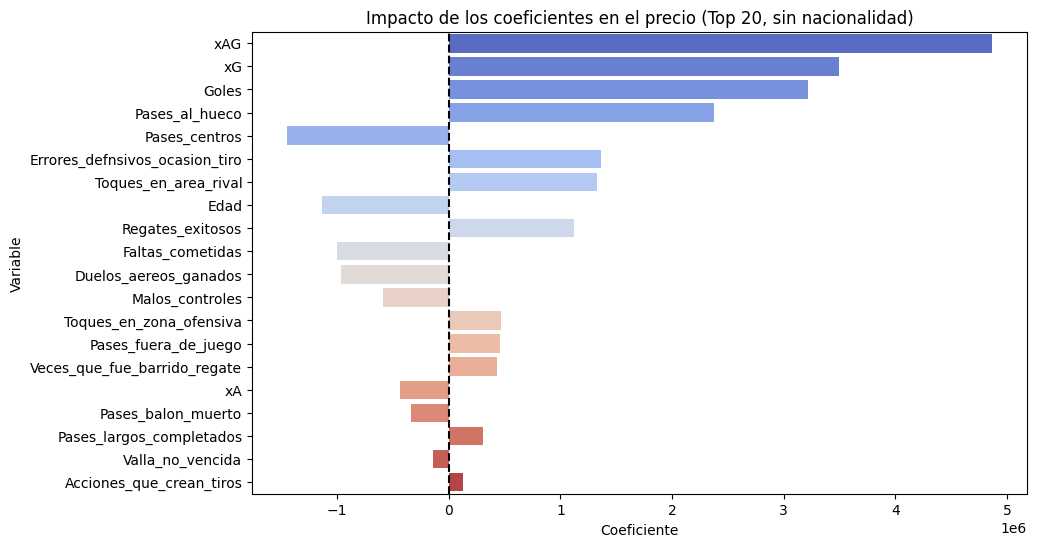

In [173]:
coeficientes = pd.DataFrame({
    "Variable": X_train.columns,
    "Coeficiente": model.coef_.ravel()
})

# Excluir variables dummy de país (ajusta el prefijo si es distinto)
coef_filtrados = coeficientes[~coeficientes["Variable"].str.startswith("Nacionalidad_")]

# Ordenar por magnitud absoluta para ver importancia real
coef_filtrados = coef_filtrados.reindex(
    coef_filtrados["Coeficiente"].abs().sort_values(ascending=False).index
)

# ============================
# Graficar
# ============================
plt.figure(figsize=(10, 6))
sns.barplot(
    data=coef_filtrados.head(20), 
    x="Coeficiente", 
    y="Variable", 
    palette="coolwarm"
)
plt.title("Impacto de los coeficientes en el precio (Top 20, sin nacionalidad)")
plt.axvline(0, color="black", linestyle="--")
plt.show()